**1. Подготовка данных**

In [ ]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2020-05-13 19:35:44--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 134.209.106.40, 2400:6180:0:d1::4d8:4001
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|134.209.106.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2679227 (2.6M) [text/csv]
Saving to: ‘owid-covid-data.csv.2’

owid-covid-data.csv 100%[===================>]   2.55M   345KB/s    in 7.7s    

2020-05-13 19:35:53 (340 KB/s) - ‘owid-covid-data.csv.2’ saved [2679227/2679227]



In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('owid-covid-data.csv')
df.date = pd.to_datetime(df.date)

In [ ]:
df.head(3)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN


In [ ]:
df = df[(df.location == 'Russia')&(df.date>='2020-03-03')][['location', "date", "total_cases", "new_cases"]]
df.index = range(len(df))
df.new_cases = df.new_cases.replace(0,1)
df['log_total_cases'] = np.log(df.total_cases)
df['time'] = range(1,len(df)+1)
df[::20]

,location,date,total_cases,new_cases,log_total_cases,time
0,Russia,2020-03-03,3,1,1.098612,1
20,Russia,2020-03-23,438,132,6.082219,21
40,Russia,2020-04-12,13584,1667,9.516648,41
60,Russia,2020-05-02,114431,7933,11.647727,61


In [ ]:
train = df.copy()[0:60]
test = df.copy()[59:]

**2. Построение графиков**

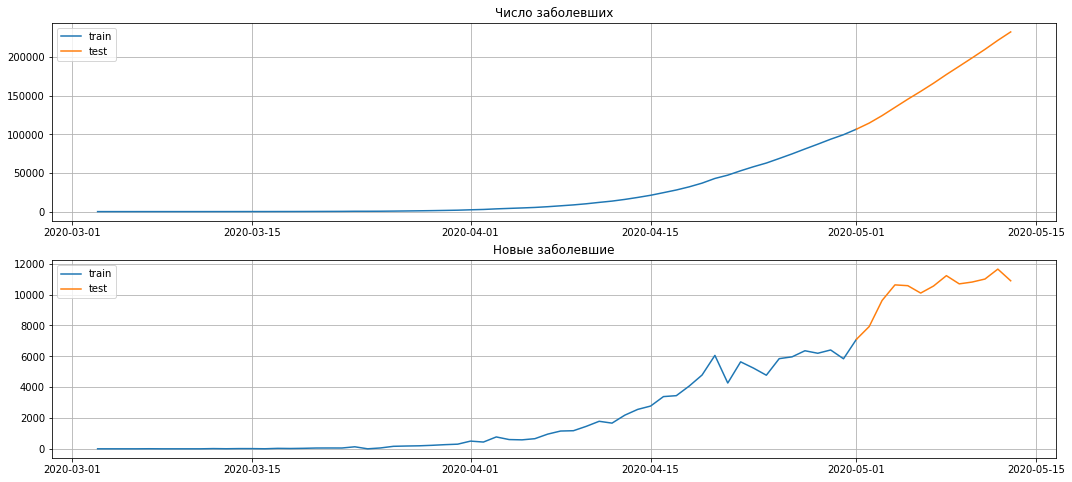

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.subplot(211)
plt.plot(train.date, train.total_cases, label = 'train')
plt.plot(test.date, test.total_cases, label = 'test')
plt.title('Число заболевших')
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.plot(train.date, train.new_cases, label = 'train')
plt.plot(test.date, test.new_cases, label = 'test')
plt.title('Новые заболевшие')
plt.grid(True)

plt.legend()
plt.show()

2a Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

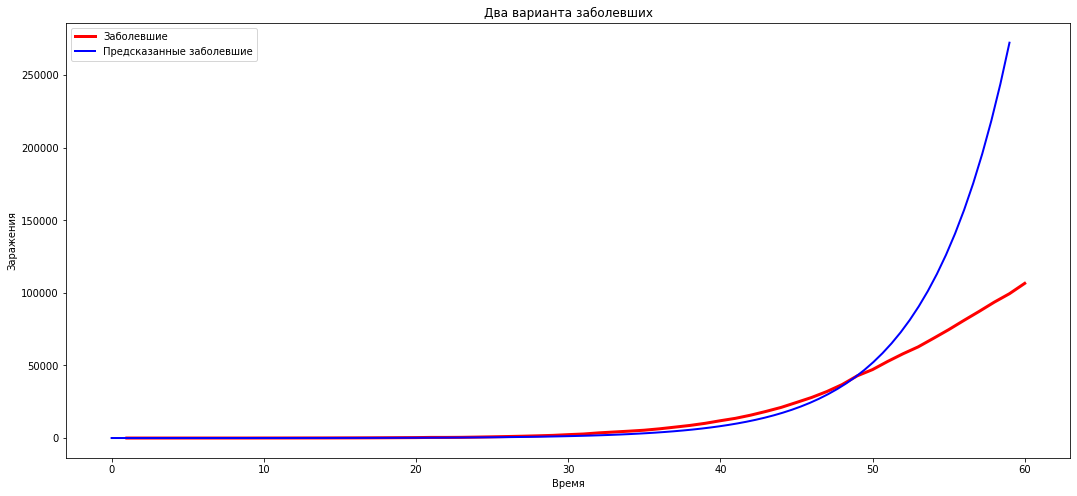

In [ ]:
from sklearn.linear_model import LinearRegression

x = train['time'].values.reshape(-1, 1)
y = train['log_total_cases'].values

genius_regression_model = LinearRegression()
genius_regression_model.fit(x,y)
w1, w0 = genius_regression_model.coef_[0], genius_regression_model.intercept_

xs = np.linspace(0, 59, 100)

plt.figure(figsize=(18, 8))
plt.plot(train.time, train.total_cases, 'red', linewidth=3, label = 'Заболевшие')
plt.plot(xs, [np.exp(x * w1 + w0)  for x in xs], 'blue', linewidth=2, label = 'Предсказанные заболевшие')
plt.title('Два варианта заболевших')
plt.xlabel('Время')
plt.ylabel('Заражения')
plt.legend()
plt.show()

2b Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели

In [ ]:
def bayesian_update(mu_0, sigma_0, X, y, noise):

    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + noise * np.matmul(np.transpose(X), X))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma_0), np.transpose(mu_0)) + noise * np.matmul(np.transpose(X), np.array(y)))
    return mu_n, sigma_n

def aposterior(x, y, noise):

    x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
    d = x.shape[1]
    mu_0 = np.zeros(d)
    sigma_0 = 10 * np.eye(d)
    
    noise_new = noise
    noise_prev = noise_new

    while True:
        mu_n, sigma_n = bayesian_update(mu_0, sigma_0, x, y, noise_new)
        predictions = np.matmul(x, mu_n)
        noise_new = 1 / np.var(y - predictions)

        if abs(noise_new - noise_prev) < 1.e-8:
            break
        else:
            noise_prev = noise_new

    return mu_n, sigma_n

In [ ]:
noise = 1 / np.var(y - genius_regression_model.predict(x))
new_mu, new_sigma = aposterior(x, y, noise)

In [ ]:
new_mu, new_sigma

(array([1.62769758, 0.18454259]), array([[ 1.78839649e-02, -4.43403932e-04],
        [-4.43403932e-04,  1.45441839e-05]]))

2с Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

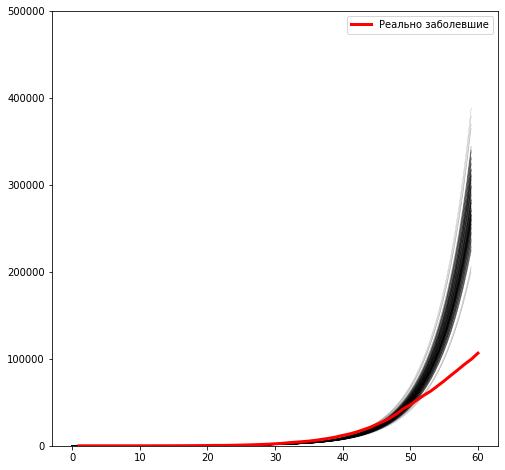

In [ ]:
# Рисуем сэмплы для апостериорного распределения
ws = np.random.multivariate_normal(new_mu, new_sigma, 200)

fig = plt.figure(figsize=(8, 8))
for w in ws:
    plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', linewidth=.4, alpha=.3)
    plt.ylim((0, 500000))
plt.plot(train.time, train.total_cases, 'red', linewidth=3, label = 'Реально заболевшие')
plt.legend()

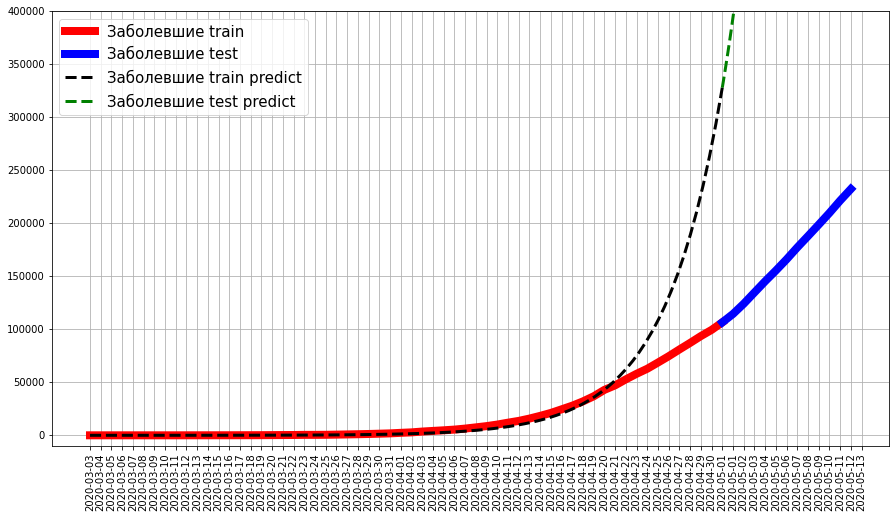

In [ ]:
# Сравниваем с тестом
xs = np.linspace(1, 60, 100)
xs_test = np.linspace(60, 70, 100)

w0, w1 = new_mu
days = []
for el in list(train.date):
    days.append(str(el)[:10])
for el in list(test.date):
    days.append(str(el)[:10])
    
plt.figure(figsize=(15, 8))
plt.plot(train.time, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(test.time, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(xs, [np.exp(x * w1 + w0)  for x in xs], 'black', linewidth=3, label = 'Заболевшие train predict', ls='--')
plt.plot(xs_test, [np.exp(x * w1 + w0)  for x in xs_test], 'green', linewidth=3, label = 'Заболевшие test predict', ls='--')
plt.xticks(ticks=range(1,len(train)+len(test)+1), labels=days, rotation=90)

plt.legend(fontsize=15)
plt.ylim(-10000,top=4e5)
plt.grid(True)

In [ ]:
predictions = {}
    
dti = pd.date_range('2020-03-03', periods=183, freq='D')
days = []
for el in list(dti):
    days.append(str(el)[:10])
    
for i in range(1,len(days)+1):
    pred = np.array([int(np.exp(i * w1 + w0)) for w0, w1 in ws])
    predictions[days[i-1]] = np.median(pred)

In [ ]:
print ('К первому мая заболеют {}, к 1 июня {}, к первому сентября {}'.format(predictions['2020-05-01'],predictions['2020-06-01'],predictions['2020-09-01']))
# Судя по прогнозу, помимо роста числа заболевших, увеличится и население страны из-за самоизоляции)) Либо все успею заболеть по паре раз.

К первому мая заболеют 327525.0, к 1 июня 100439088.5, к первому сентября 2425748324193236.5


**3. То же самое, но для сигмоиды**

Общее число заболевших на данную дату можно определять как кумулятивную сумму от прогнозов модели для новых случаев: $total \; cases_n = \sum_{i=0}^n new\;cases_i$

In [ ]:
x = np.asarray(train.time).reshape(-1, 1)
x = np.concatenate((x, x ** 2), axis=1)

train['log_new_cases'] = np.log(train.new_cases)
test['log_new_cases'] = np.log(test.new_cases)

y = train['log_new_cases']

genius_regression_model = LinearRegression(fit_intercept=True).fit(x, y)

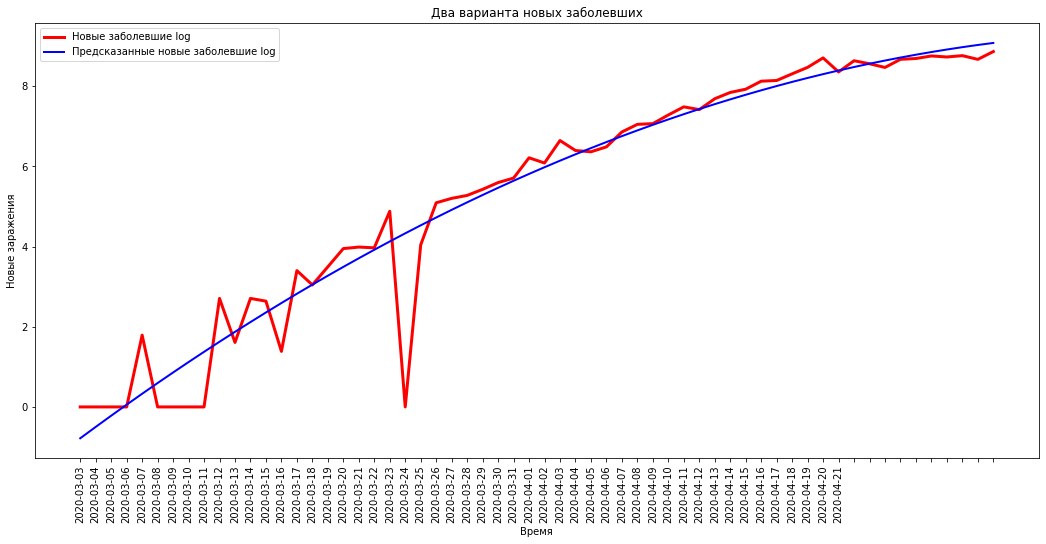

In [ ]:
train['time**2'] = train.time**2
test['time**2'] = test.time**2

plt.figure(figsize=(18, 8))
plt.plot(train.time, train.log_new_cases, 'red', linewidth=3, label = 'Новые заболевшие log')
plt.plot(train.time, genius_regression_model.predict(x), 'blue', linewidth=2, label = 'Предсказанные новые заболевшие log')
plt.title('Два варианта новых заболевших')
plt.xlabel('Время')
plt.ylabel('Новые заражения')
plt.xticks(ticks=range(1,len(train)+1), labels=days[0:50], rotation=90)
plt.legend()
plt.show()

In [ ]:
x_ = np.arange(1,150).reshape(-1, 1)
x_ = np.concatenate((x_, x_ ** 2), axis=1)

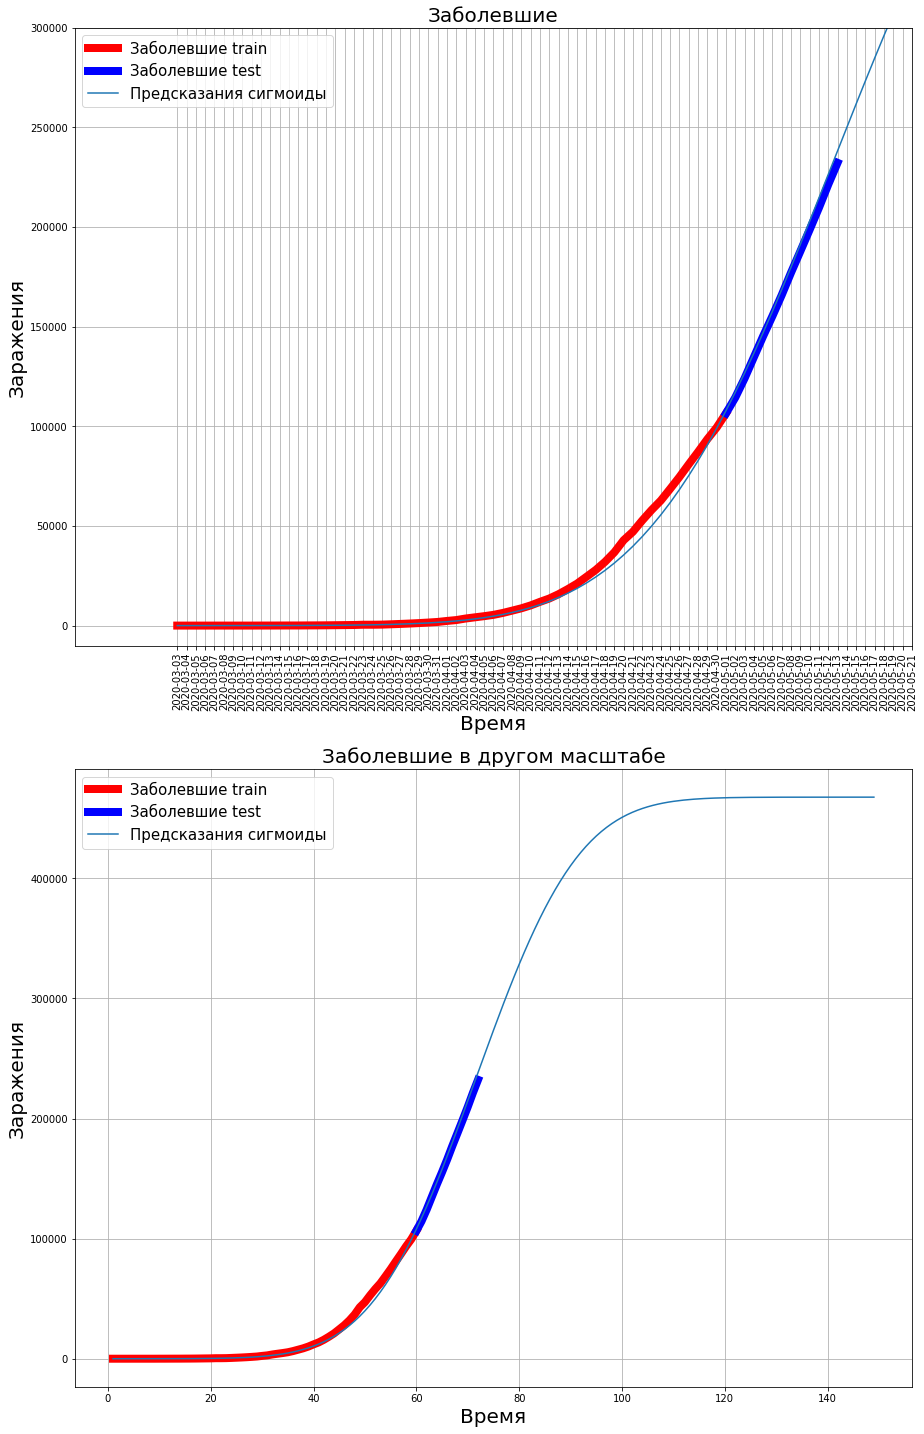

In [ ]:
preds = np.exp(genius_regression_model.predict(x_))
preds_cumsum = np.cumsum(preds)

plt.figure(figsize=(15,25))
plt.subplot(211)
plt.title('Заболевшие', fontsize=20)
plt.xlabel('Время', fontsize=20)
plt.ylabel('Заражения', fontsize=20)
plt.plot(train.time, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(test.time, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(np.arange(1,150),preds_cumsum, label = 'Предсказания сигмоиды')
plt.xticks(ticks=range(1,150), labels=days, rotation=90)

plt.legend(fontsize=15)
plt.ylim(-10000,top=3e5)
plt.xlim(-10, 80)
plt.grid(True)

plt.subplot(212)
plt.title('Заболевшие в другом масштабе', fontsize=20)
plt.xlabel('Время', fontsize=20)
plt.ylabel('Заражения', fontsize=20)
plt.plot(train.time, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(test.time, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(np.arange(1,150),preds_cumsum, label = 'Предсказания сигмоиды')
plt.legend(fontsize=15)
plt.grid(True)

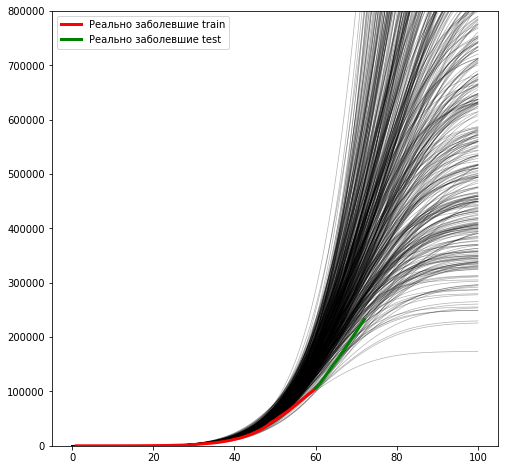

In [ ]:
# Рисуем сэмплы сигмоид

xs = np.linspace(0, 100, 150)
noise = 1 / np.var(y - genius_regression_model.predict(x))
new_mu, new_sigma = aposterior(x, y, noise)

ws = np.random.multivariate_normal(new_mu, new_sigma, 500)

preds_ = []

fig = plt.figure(figsize=(8, 8))
for w in ws:
    pred = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
    preds_.append(pred)
    plt.plot(xs, pred, 'k-', linewidth=.7, alpha=.3)
    plt.ylim((0, 800000))
plt.plot(train.time, train.total_cases, 'red', linewidth=3, label = 'Реально заболевшие train')
plt.plot(test.time, test.total_cases, 'green', linewidth=3, label = 'Реально заболевшие test')
plt.legend()

Процентили

In [ ]:
preds_ = np.array(preds_)
median_preds = np.mean(preds_, axis=0)
median_preds[::20]

array([3.66091788e-01, 7.54462939e+01, 1.54380957e+03, 1.60569349e+04,
       8.87447179e+04, 2.81217288e+05, 5.73904877e+05, 8.63293993e+05])

In [ ]:
print ('При пессимистичном сценарии в РФ заболеет {} человек, а при оптимистичном {}. Оптимистичного уже не видать((('.format(int(np.percentile(median_preds, 90)), int(np.percentile(median_preds, 10))))

При пессимистичном сценарии в РФ заболеет 783892 человек, а при оптимистичном 30. Оптимистичного уже не видать(((


Моделирование для Китая

In [ ]:
df = pd.read_csv('owid-covid-data.csv')
df.date = pd.to_datetime(df.date)
df = df[(df.location == 'China')][['location', "date", "total_cases", "new_cases"]]
df.index = range(len(df))
df.new_cases = df.new_cases.replace(0,1)
df['log_total_cases'] = np.log(df.total_cases)
df['time'] = range(1,len(df)+1)
train = df.copy()[0:60]
test = df.copy()[60:]
df

,location,date,total_cases,new_cases,log_total_cases,time
0,China,2019-12-31,27,27,3.295837,1
1,China,2020-01-01,27,1,3.295837,2
2,China,2020-01-02,27,1,3.295837,3
3,China,2020-01-03,44,17,3.784190,4
4,China,2020-01-04,44,1,3.784190,5
...,...,...,...,...,...,...
130,China,2020-05-09,83976,1,11.338286,131
131,China,2020-05-10,83991,15,11.338465,132
132,China,2020-05-11,84010,19,11.338691,133
133,China,2020-05-12,84011,1,11.338703,134


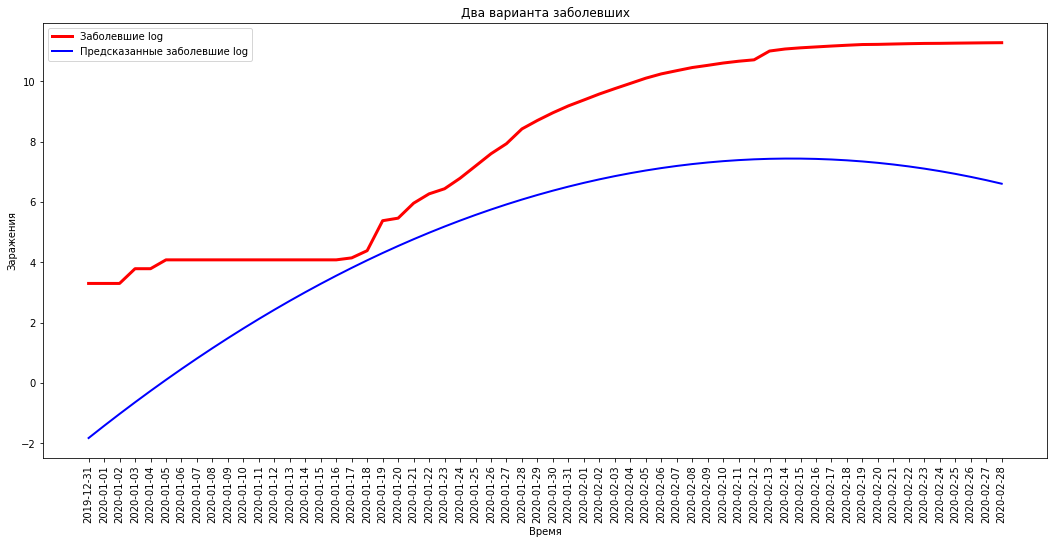

In [ ]:
dti = pd.date_range('2019-12-31', periods=100, freq='D')
days = []
for el in list(dti):
    days.append(str(el)[:10])

x = np.asarray(train.time).reshape(-1, 1)
x = np.concatenate((x, x ** 2), axis=1)

train['log_new_cases'] = np.log(train.new_cases)
test['log_new_cases'] = np.log(test.new_cases)

y = train['log_new_cases']

genius_regression_model = LinearRegression(fit_intercept=True).fit(x, y)

train['time**2'] = train.time**2
test['time**2'] = test.time**2

plt.figure(figsize=(18, 8))
plt.plot(train.time, train.log_total_cases, 'red', linewidth=3, label = 'Заболевшие log')
plt.plot(train.time, genius_regression_model.predict(x), 'blue', linewidth=2, label = 'Предсказанные заболевшие log')
plt.title('Два варианта заболевших')
plt.xlabel('Время')
plt.ylabel('Заражения')
plt.xticks(ticks=range(1,len(train)+1), labels=days[0:60], rotation=90)
plt.legend()
plt.show()

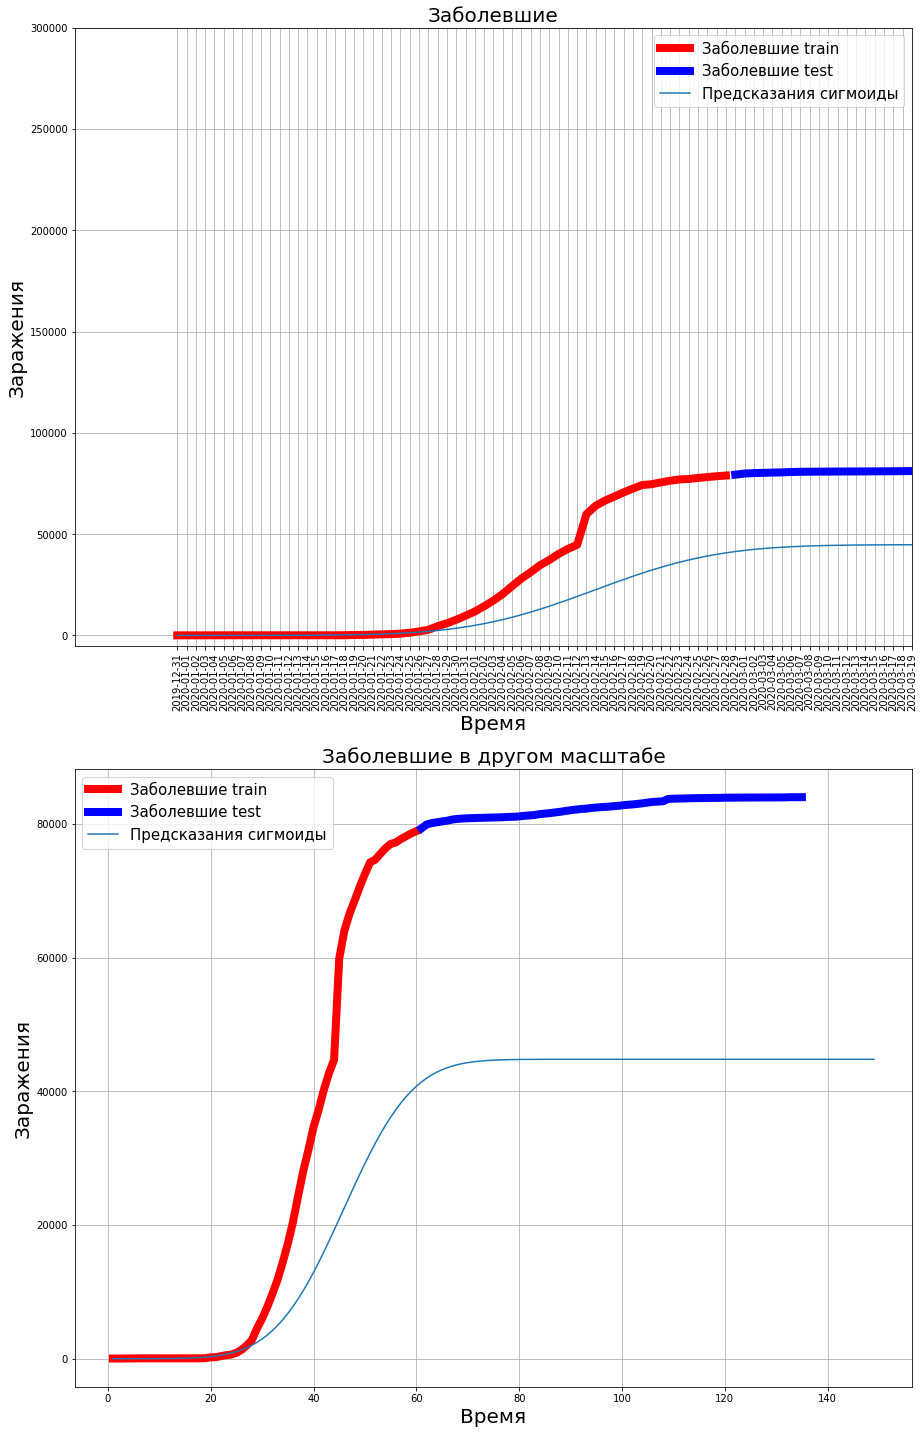

In [ ]:
x_ = np.arange(1,150).reshape(-1, 1)
x_ = np.concatenate((x_, x_ ** 2), axis=1)

preds = np.exp(genius_regression_model.predict(x_))
preds_cumsum = np.cumsum(preds)

plt.figure(figsize=(15,25))
plt.subplot(211)
plt.title('Заболевшие', fontsize=20)
plt.xlabel('Время', fontsize=20)
plt.ylabel('Заражения', fontsize=20)
plt.plot(train.time, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(test.time, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(np.arange(1,150),preds_cumsum, label = 'Предсказания сигмоиды')
plt.xticks(ticks=range(1,150), labels=days, rotation=90)

plt.legend(fontsize=15)
plt.ylim(-5000,top=3e5)
plt.xlim(-10, 80)
plt.grid(True)

plt.subplot(212)
plt.title('Заболевшие в другом масштабе', fontsize=20)
plt.xlabel('Время', fontsize=20)
plt.ylabel('Заражения', fontsize=20)
plt.plot(train.time, train.total_cases, 'red', linewidth=8, label = 'Заболевшие train')
plt.plot(test.time, test.total_cases, 'blue', linewidth=8, label = 'Заболевшие test')
plt.plot(np.arange(1,150),preds_cumsum, label = 'Предсказания сигмоиды')
plt.legend(fontsize=15)
plt.grid(True)

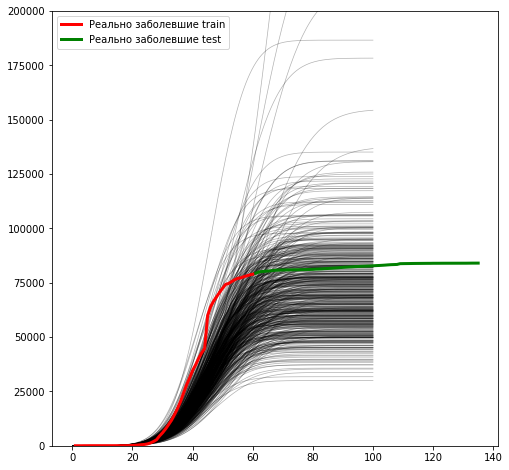

In [ ]:
# Рисуем сэмплы сигмоид

xs = np.linspace(0, 100, 150)
noise = 1 / np.var(y - genius_regression_model.predict(x))
new_mu, new_sigma = aposterior(x, y, noise)

ws = np.random.multivariate_normal(new_mu, new_sigma, 500)

preds_ = []

fig = plt.figure(figsize=(8, 8))
for w in ws:
    pred = np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))
    preds_.append(pred)
    plt.plot(xs, pred, 'k-', linewidth=.7, alpha=.3)
    plt.ylim((0, 200000))
plt.plot(train.time, train.total_cases, 'red', linewidth=3, label = 'Реально заболевшие train')
plt.plot(test.time, test.total_cases, 'green', linewidth=3, label = 'Реально заболевшие test')
plt.legend()

5

Как-то так. Прогнозировать довольно сложно. Оптимальную модель для всех стран не сделать. слишком много факторов, которые не отражены в общем количестве заражений. Но модель линейной регрессии можно использовать в этой работе.

Не все процессы в жизни можно смоделировать. При работе с этим ДЗ просмотрел много ноутбуков на covid-19, очень много мнений, и не нашел оптимльного решения.

Если бы в датасете была информация о периодах карантина, то, возможно, мы смогли бы понять влияние карантина на распространение болезни. 